<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/isolation_forest_2D_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isolation Forest (2D) — Notebook Comentado

Este notebook implementa **Isolation Forest** do zero, com explicações passo a passo em português.

**Resumo do que você verá:**
1. Geração de dados sintéticos (3 clusters gaussianos + 10 outliers).
2. Implementação de uma árvore de isolamento (nó recursivo).
3. Função de comprimento de caminho (*path length*) e fator de normalização `c(n)`.
4. Implementação da floresta de isolamento (conjunto de árvores aleatórias).
5. Treinamento, cálculo de *scores* de anomalia e visualização em 2D.


## Importações

Utilizaremos `numpy`, `matplotlib` e `scikit-learn` apenas para **gerar dados**;
toda a lógica do Isolation Forest é codificada manualmente aqui.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Garantir reprodutibilidade global adicional (além dos pontos do make_blobs)
np.random.seed(7)

## Geração de dados: 3 clusters + 10 outliers artificiais

- `make_blobs` gera dados agrupados com distribuição normal (gaussiana) ao redor de centros.
- `centers=3` cria três grupos distintos.
- `cluster_std=0.60` controla a dispersão de cada grupo.
- `random_state=7` fixa a semente para reprodutibilidade.
- Outliers são amostrados **uniformemente** em `[-6, 6]` em cada eixo.


In [2]:
# Dados majoritariamente "normais" (três aglomerados) + outliers uniformes
X_normal, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=7)
X_outliers = np.random.uniform(low=-6, high=6, size=(10, 2))
X = np.vstack([X_normal, X_outliers])

print(f"Formas: X_normal = {X_normal.shape}, X_outliers = {X_outliers.shape}, X = {X.shape}")

Formas: X_normal = (300, 2), X_outliers = (10, 2), X = (310, 2)


### Visualização inicial dos dados (sem modelo)

Pontos dos três *clusters* (em azul) e dos outliers misturados (ainda sem distinção visual).


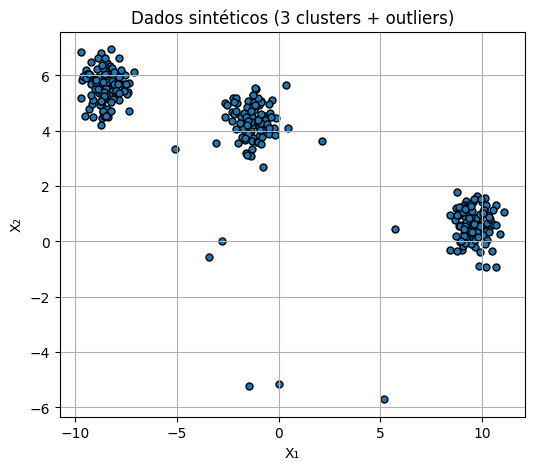

In [3]:
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], s=25, edgecolors='k')
plt.title("Dados sintéticos (3 clusters + outliers)")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.grid(True)
plt.show()

## Nó de Árvore de Isolamento (`IsolationTreeNode`)

Cada nó escolhe aleatoriamente:
- **uma feature** (coluna) dentre as disponíveis;
- **um valor de corte (split)** uniforme entre `min` e `max` da feature naquele nó.

A recursão prossegue até atingir a **profundidade máxima** (`max_depth`) ou um **nó terminal** (1 amostra).


In [4]:
class IsolationTreeNode:
    def __init__(self, depth=0, max_depth=None):
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None
        self.depth = depth
        self.max_depth = max_depth
        self.n_samples = None

    def fit(self, X):
        """Constroi recursivamente a árvore de isolamento.
        Critérios de parada:
        - profundidade >= max_depth, ou
        - número de amostras <= 1, ou
        - todos os valores da feature escolhida iguais (split impossível).
        """
        self.n_samples = X.shape[0]
        if self.depth >= self.max_depth or self.n_samples <= 1:
            return

        # Escolhe uma variável aleatória e um valor de corte aleatório
        self.split_feature = np.random.randint(0, X.shape[1])
        min_val, max_val = X[:, self.split_feature].min(), X[:, self.split_feature].max()
        if min_val == max_val:
            # Não é possível dividir nesta feature
            return
        self.split_value = np.random.uniform(min_val, max_val)

        # Separa os dados em dois subconjuntos
        left_mask = X[:, self.split_feature] < self.split_value
        X_left = X[left_mask]
        X_right = X[~left_mask]

        # Cria nós filhos recursivamente
        self.left = IsolationTreeNode(depth=self.depth + 1, max_depth=self.max_depth)
        self.left.fit(X_left)

        self.right = IsolationTreeNode(depth=self.depth + 1, max_depth=self.max_depth)
        self.right.fit(X_right)

## Comprimento de caminho (*path length*) e fator de normalização `c(n)`

- O **comprimento de caminho** de uma amostra é a profundidade em que ela é isolada.
- Nós terminais com mais de 1 amostra usam a correção **`c(n)`**, que aproxima a
  profundidade média esperada de uma busca em árvore binária aleatória.

A constante de Euler–Mascheroni \(\gamma \approx 0{,}5772\) aparece na expressão fechada de `c(n)`.


In [5]:
def c_factor(n: int) -> float:
    """Fator de normalização c(n):
    c(n) = 0,  se n <= 1
           2 * (ln(n-1) + gamma) - 2*(n-1)/n,  se n > 1
    """
    if n <= 1:
        return 0.0
    gamma = 0.5772156649  # constante de Euler–Mascheroni
    return 2.0 * (np.log(n - 1) + gamma) - (2.0 * (n - 1) / n)


def path_length(x: np.ndarray, node: IsolationTreeNode) -> float:
    """Calcula recursivamente o comprimento de caminho para o ponto x na árvore dada.
    - Se chegamos a um nó folha (sem filhos), retornamos a profundidade, com ajuste por c(n) quando n>1.
    - Caso contrário, seguimos à esquerda/direita conforme o split.
    """
    if node.left is None or node.right is None:
        if node.n_samples is None:
            return node.depth  # fallback
        if node.n_samples <= 1:
            return node.depth
        return node.depth + c_factor(node.n_samples)

    if x[node.split_feature] < node.split_value:
        return path_length(x, node.left)
    else:
        return path_length(x, node.right)

## Floresta de Isolamento (`IsolationForest`)

- Constrói **`n_estimators`** árvores, cada uma treinada em um **subconjunto aleatório** de tamanho `max_samples`.
- A profundidade máxima padrão é \(\lceil \log_2(\text{max\_samples}) \rceil\), conforme a teoria do algoritmo.
- O *score* de anomalia de um ponto é \( 2^{-\frac{E(h(x))}{c(\text{amostra})}} \), onde \(E(h(x))\) é o comprimento médio de caminho.


In [7]:
class IsolationForest:
    def __init__(self, n_estimators=100, max_samples=256, max_depth=None):
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth
        self.trees = []
        self.sample_size = None

    def fit(self, X: np.ndarray):
        """Treina a floresta, construindo árvores com amostras aleatórias de tamanho `max_samples`.
        A profundidade limite padrão é ceil(log2(sample_size)) se max_depth não for fornecida.
        """
        self.trees = []
        self.sample_size = int(min(self.max_samples, X.shape[0]))
        height_limit = int(np.ceil(np.log2(self.sample_size))) if self.max_depth is None else int(self.max_depth)

        for _ in range(self.n_estimators):
            indices = np.random.choice(X.shape[0], self.sample_size, replace=False)
            X_subset = X[indices]
            root = IsolationTreeNode(depth=0, max_depth=height_limit)
            root.fit(X_subset)
            self.trees.append(root)

    def score_samples(self, X: np.ndarray) -> np.ndarray:
        """Calcula o score de anomalia para cada amostra:
        score(x) = 2 ^ ( - E[h(x)] / c(sample_size) )
        Valores maiores indicam maior probabilidade de anomalia.
        """
        scores = np.zeros(X.shape[0], dtype=float)
        normalizer = c_factor(self.sample_size)
        for i, x in enumerate(X):
            path_lengths = [path_length(x, tree) for tree in self.trees]
            avg_path_length = np.mean(path_lengths)
            scores[i] = 2.0 ** (-avg_path_length / normalizer) if normalizer > 0 else 0.0
        return scores

## Treinamento e *scores* de anomalia

- Treinamos a floresta com `n_estimators=100` e `max_samples=256`.
- Calculamos os *scores* para todas as amostras.
- Definimos um **limiar** como o percentil 95 (top 5% são marcados como outliers).


In [8]:
# Treinamento
model = IsolationForest(n_estimators=100, max_samples=256)
model.fit(X)

# Score de anomalia por ponto
scores = model.score_samples(X)

# Limiar: 5% com maior score são outliers
threshold = np.percentile(scores, 95)
labels = (scores >= threshold).astype(int)  # 1 = outlier, 0 = normal

print(f"Limiar (95º percentil): {threshold:.4f}")
print(f"Qtde outliers sinalizados: {labels.sum()} de {len(labels)} amostras")

Limiar (95º percentil): 0.5698
Qtde outliers sinalizados: 16 de 310 amostras


## Visualização 2D — destaque para outliers

Os pontos marcados como outliers (1) aparecem em uma cor distinta.


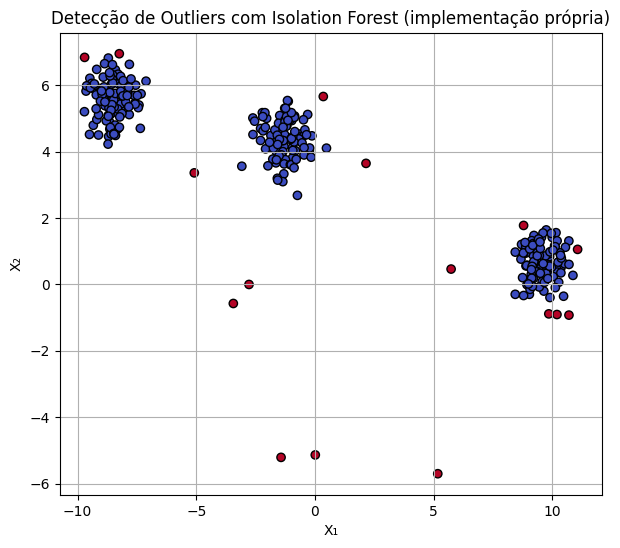

In [9]:
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', edgecolors='k')
plt.title("Detecção de Outliers com Isolation Forest (implementação própria)")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.grid(True)
plt.show()

## Exploração rápida (opcional)

Você pode ajustar parâmetros e observar o efeito no resultado:
- `n_estimators`: mais árvores → estimativa mais estável (custo ↑).
- `max_samples`: define o tamanho da amostragem por árvore e o normalizador `c(n)`.
- Percentil do limiar para classificar outliers (ex.: 90, 95, 99).


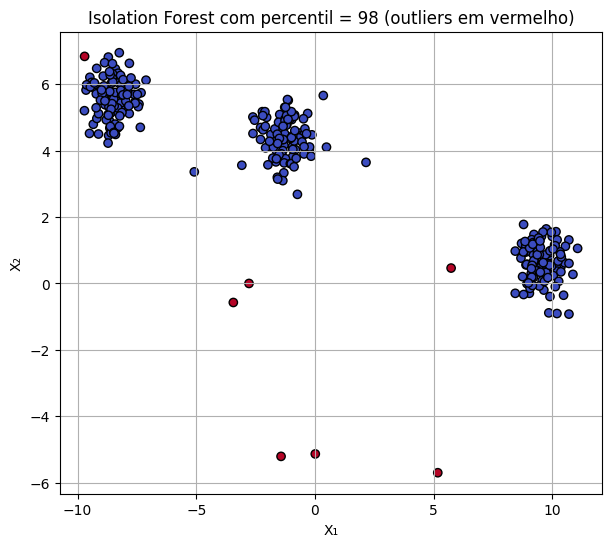

Percentil usado: 98 | Limiar=0.6450 | Outliers=7 de 310


In [12]:
# Experimento opcional: altere e reexecute
percentil = 98  # ajuste: 90, 95, 97, 99...
model2 = IsolationForest(n_estimators=200, max_samples=300)
model2.fit(X)
scores2 = model2.score_samples(X)
thr2 = np.percentile(scores2, percentil)
labels2 = (scores2 >= thr2).astype(int)

plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels2, cmap='coolwarm', edgecolors='k')
plt.title(f"Isolation Forest com percentil = {percentil} (outliers em vermelho)")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.grid(True)
plt.show()

print(f"Percentil usado: {percentil} | Limiar={thr2:.4f} | Outliers={labels2.sum()} de {len(labels2)}")